In [1]:
#!pip install pandas
#!pip install seaborn
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import pandas as pd
import numpy as np
from pandas import read_csv

test= pd.read_csv('test.csv')
train= pd.read_csv('train.csv')

all_data = pd.concat([train, test])

In [3]:
all_data['engine'] = all_data['engine'].str.replace('Liter', 'L')

def extract_data_from_engine(all_data):
    all_data=all_data.copy()
    all_data['horsepower'] = all_data['engine'].str.extract(r'(\d+\.\d+)(?=HP)').astype(float)
    all_data['engine_size'] = all_data['engine'].str.extract(r'(\d+\.\d+)(?=L)' or '(\d+\.\d+)(?= Liter)' ).astype(float)
    all_data['cylinders'] = all_data['engine'].str.extract(r'(\d+)\s(Cylinder|V\d+|Straight)')[0].astype(float)
    all_data['eletric_vol'] = all_data['engine'].str.extract(r'(\d+)V')[0].astype(float)
#filling empty in fuel column filling empty values of fuel type and changing eletric to hybrid
    all_data['engine_extract'] = all_data['engine'].str.extract(r'(Gasoline|Diesel|Flex Fuel|Hybrid|Plug-In Hybrid|Electric)')[0]
    all_data.loc[(all_data['engine'] == '-') & (all_data['accident'].isnull()) & (all_data['milage']>2000), 'accident'] = 'At least 1 accident or damage reported' #Added requested condition
    all_data.loc[all_data['engine'].str.contains("Twin Turbo"), 'twin_turbo'] = True
    all_data['twin_turbo'] = all_data['twin_turbo'].fillna(False)
    return all_data
all_data = extract_data_from_engine(all_data)

<ipython-input-3-2a1865a0cbe3>:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_data['twin_turbo'] = all_data['twin_turbo'].fillna(False)


In [4]:
 #Fill missing values in 'fuel_type' with corresponding values from 'engine_extract'
all_data['fuel_type'] = all_data['fuel_type'].fillna(all_data['engine_extract'])

In [5]:
current_year = 2024
all_data['Vehicle_Age'] = current_year - all_data['model_year']
all_data['Mileage_per_Year'] = all_data['milage'] / (all_data['Vehicle_Age'] + 10e-5)
all_data['brand'] = all_data['brand'].str.lower()
all_data['ext_col'] = all_data['ext_col'].str.lower()
all_data['transmission'] = all_data['transmission'].str.lower()
all_data['int_col'] = all_data['int_col'].str.lower()

In [6]:
all_data['antique'] = all_data['Vehicle_Age'].apply(lambda x: 1 if x < 20 else 0)

all_data['new'] = all_data['milage'].apply(lambda x: 1 if x < 200 else 0)

In [7]:
luxury_brands = ['lamborghini', 'bugatti', 'rolls-royce','bentley', 'mclaren', 'ferrari', 'aston','rivian']
all_data['luxury'] = all_data['brand'].apply(lambda x: 1 if x in luxury_brands else 0)


In [8]:
def extract_data_from_col_ext(all_data):
    all_data = all_data.copy()
    counts = all_data['ext_col'].value_counts()
    all_data['ext_col_u'] = all_data['ext_col'].apply(lambda x: 1 if counts[x] < 100 else 0)
    return all_data
all_data = extract_data_from_col_ext(all_data)


In [9]:
def extract_data_from_col_int(all_data):
    counts = all_data['int_col'].value_counts()
    all_data['int_col_u'] = all_data['int_col'].apply(lambda x: 1 if counts[x] < 100 else 0)
    return all_data
all_data = extract_data_from_col_int(all_data)

In [10]:
all_data['transmission_auto'] = all_data['transmission'].apply(lambda x: 1 if 'automatic' in x or 'a/t' in x else 0)


In [11]:
# Calculate the average horsepower for each brand
avg_horsepower_by_brand = all_data.groupby('brand')['horsepower'].mean()

# Fill nulls in horsepower with the average horsepower for the corresponding brand
all_data['horsepower'] = all_data.apply(
    lambda row: avg_horsepower_by_brand[row['brand']] if pd.isnull(row['horsepower']) else row['horsepower'],
    axis=1
)

In [12]:
all_data['accidents_count'] = all_data.groupby('brand')['accident'].transform('count')

In [13]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

object_cols = ['brand','model', 'fuel_type', 'int_col','ext_col', 'accident', 'clean_title','transmission']

label_encoder = LabelEncoder()

for col in object_cols:
    # Convert all values to strings before fitting the encoder
    all_values = pd.concat([all_data[col]]).astype(str).unique()
    label_encoder.fit(all_values)

    all_data[col] = label_encoder.transform(all_data[col].astype(str))

In [14]:
train = all_data.dropna(subset=['price'])
test = all_data[all_data['price'].isnull()]

test1 = test.copy()
test1 = test['id']


train = train.drop(['id','engine','engine_extract'], axis=1) # Dropping columns from the train DataFrame
test = test.drop(['id','engine','price','engine_extract'], axis=1) # Dropping columns from the test DataFrame

# train1 = train.drop(['id', 'model','engine','price','engine_extract','int_col','ext_col','ext_col_u','int_col_u'],axis =1)
# test1 = test.drop(['id','model','engine','engine_extract','int_col','ext_col','ext_col_u','int_col_u'], axis = 1)

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [16]:
best_params = {
    'n_estimators': 1225,
    'num_leaves': 137,
    'max_depth': 17,
    'cat_smooth': 96,
    'learning_rate': 0.02,
    'subsample': 0.9082095260228584,
    'colsample_bytree': 0.6165900236226695,
    'min_split_gain': 0.0308677316309982,
    'min_child_weight': 32,
    'lambda_l2': 1.7319600391087514e-07,
    'lambda_l1': 8.761594422544116e-07,
    'max_bin': 749,
    'objective': 'regression',
    'metric': 'rmse',
    'random_state': 42,
    'boosting_type': 'gbdt',
}

## {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31} - optional

In [17]:
lgb_model = lgb.LGBMRegressor(**best_params)

callbacks = [
    lgb.early_stopping(stopping_rounds=500),
    lgb.log_evaluation(100)
]

In [18]:
train.head()

,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,...,twin_turbo,Vehicle_Age,Mileage_per_Year,antique,new,luxury,ext_col_u,int_col_u,transmission_auto,accidents_count
0,37,495,2007,213000,4,37,313,69,1,0,...,False,17,12529.338063,1,0,0,0,0,1,1737
1,28,930,2002,143250,4,37,264,8,0,0,...,False,22,6511.334039,0,0,0,0,0,1,3973
2,9,1575,2002,136731,1,37,36,69,1,0,...,False,22,6215.017204,0,0,0,0,0,1,26671
3,15,758,2017,19500,4,48,26,12,1,0,...,False,7,2785.674490,1,0,0,0,0,0,1587
4,35,1077,2021,7388,4,23,26,8,1,0,...,False,3,2462.584581,1,0,0,0,0,1,31777


In [19]:
train1 = train.drop(['price'], axis=1)
fit1 = train['price']

In [20]:
lgb_model.fit(
    train1, fit1,
    eval_set=[(train1, fit1)],
    eval_metric='rmse',
    callbacks=callbacks
 )

[LightGBM] [Warning] lambda_l2 is set=1.7319600391087514e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7319600391087514e-07
[LightGBM] [Warning] lambda_l1 is set=8.761594422544116e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.761594422544116e-07
[LightGBM] [Warning] lambda_l2 is set=1.7319600391087514e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7319600391087514e-07
[LightGBM] [Warning] lambda_l1 is set=8.761594422544116e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.761594422544116e-07
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3441
[LightGBM] [Info] Number of data points in the train set: 188533, number of used features: 24
[LightGBM] [Info] Start training from score 43878.016178


/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:341: UserWarning: Only training set found, disabling early stopping.
  _log_warning("Only training set found, disabling early stopping.")


[100]	training's rmse: 70233
[200]	training's rmse: 68087.9
[300]	training's rmse: 66658.2
[400]	training's rmse: 65593.6
[500]	training's rmse: 64663.2
[600]	training's rmse: 63899.6
[700]	training's rmse: 63214.5
[800]	training's rmse: 62593.9
[900]	training's rmse: 61965.3
[1000]	training's rmse: 61390
[1100]	training's rmse: 60848.2
[1200]	training's rmse: 60335


LGBMRegressor(cat_smooth=96, colsample_bytree=0.6165900236226695,
              lambda_l1=8.761594422544116e-07, lambda_l2=1.7319600391087514e-07,
              learning_rate=0.02, max_bin=749, max_depth=17, metric='rmse',
              min_child_weight=32, min_split_gain=0.0308677316309982,
              n_estimators=1225, num_leaves=137, objective='regression',
              random_state=42, subsample=0.9082095260228584)

In [21]:
# pred1 = lgb_model.predict(test)
#pred1 = np.clip(pred1, 2000, None)

In [22]:
pred2 = lgb_model.predict(train1)

[LightGBM] [Warning] lambda_l2 is set=1.7319600391087514e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7319600391087514e-07
[LightGBM] [Warning] lambda_l1 is set=8.761594422544116e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.761594422544116e-07


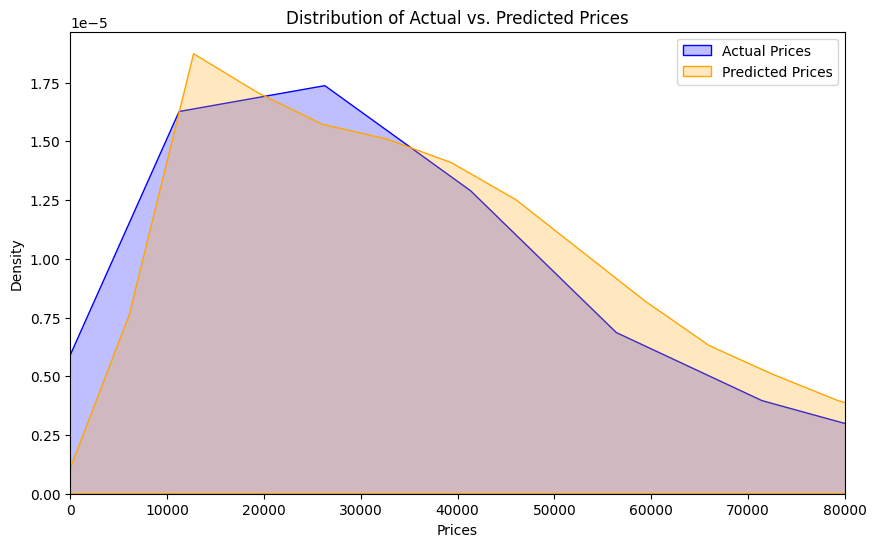

In [23]:
plt.figure(figsize=(10, 6))
sns.kdeplot(fit1, label='Actual Prices', color='blue', fill=True)
sns.kdeplot(pred2, label='Predicted Prices', color='orange', fill=True)
plt.xlabel("Prices")
plt.ylabel("Density")
plt.title("Distribution of Actual vs. Predicted Prices")
plt.legend()
plt.xlim(0, 80000)
plt.show()

In [24]:
import pickle
data = {'model': lgb_model}
with open('saved_steps.pkl', 'wb') as file:
    pickle.dump(data, file)